## Importing necessary libraries


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import time
from sklearn.metrics import confusion_matrix, roc_curve, auc,precision_score, accuracy_score, f1_score
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

## Getting the Dataset

In [ ]:
# Import dataset from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Copy from drive to /content folder
!cp -r "/content/drive/MyDrive/DTSC 5082/dataverse_files.zip" /content/

In [ ]:
#Unzipping the data_verse.zip (our dataset) to a folder named HAM10000
!unzip -qq "/content/dataverse_files.zip" -d HAM10000

In [ ]:
# Files inside HAM10000 zip file
import os
os.listdir("HAM10000")

['HAM10000_images_part_1.zip',
 'ISIC2018_Task3_Test_NatureMedicine_AI_Interaction_Benefit.csv',
 'HAM10000_metadata',
 'ISIC2018_Task3_Test_GroundTruth.csv',
 'HAM10000_segmentations_lesion_tschandl.zip',
 'HAM10000_images_part_2.zip',
 'ISIC2018_Task3_Test_Images.zip']

In [ ]:
# Unzipping part 1 and part 2 images into single part
!unzip -qq HAM10000/HAM10000_images_part_1.zip -d HAM10000/images/
!unzip -qq HAM10000/HAM10000_images_part_2.zip -d HAM10000/images/

### Data Analysis & Data Visualization

In [ ]:
# Identifying metadata file and reading it into a pandas dataframe
import pandas as pd
metadata_path = "/content/HAM10000/HAM10000_metadata"
metadata = pd.read_csv(metadata_path)

# Loading first few rows of metadata
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [ ]:
# Summary Statistics

print("=== Summary Statistics ===")
print("Shape of Metadata :",metadata.shape)
print(f"\nTotal number of records: {len(metadata)}")
print("\nColumns: \n",metadata.columns)
print(f"\nMean age: {metadata['age'].mean():.2f} years")
print(f"Age range: {metadata['age'].min()} - {metadata['age'].max()}")
print("\nSex Distribution:")
print(metadata['sex'].value_counts())
print("\nLocalization Distribution:")
print(metadata['localization'].value_counts())

=== Summary Statistics ===
Shape of Metadata : (10015, 8)

Total number of records: 10015

Columns: 
 Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dataset'],
      dtype='object')

Mean age: 51.86 years
Age range: 0.0 - 85.0

Sex Distribution:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

Localization Distribution:
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


In [ ]:
# Counting no of images in the images folder
images_dir = "HAM10000/images/"
images = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
print(f"Total extracted images: {len(images)}")

Total extracted images: 10015


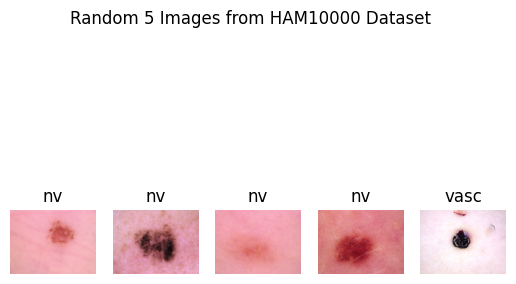

In [ ]:
image_files = os.listdir(images_dir)
random_images = random.sample(image_files, 5)

for i, image_name in enumerate(random_images):
    img_path = os.path.join(images_dir, image_name)
    img = mpimg.imread(img_path)

    # Getting metadata for current image
    img_meta = metadata[metadata['image_id'] == image_name.split('.')[0]]
    diagnosis = img_meta['dx'].values[0] if not img_meta.empty else 'Unknown'

    # Display
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(diagnosis)

plt.suptitle('Random 5 Images from HAM10000 Dataset')
plt.show()

In [ ]:
metadata['age'] = pd.to_numeric(metadata['age'], errors='coerce')  # Ensure age is numeric
metadata['sex'] = metadata['sex'].fillna('unknown')  # Handle missing sex
metadata['localization'] = metadata['localization'].fillna('unknown')  # Handle missing localization

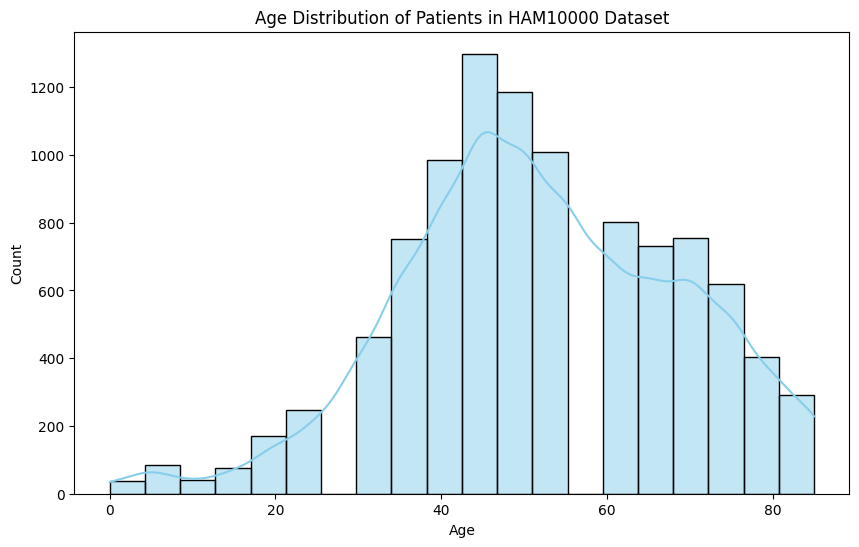

In [ ]:
#Age Distribution Histogram

plt.figure(figsize=(10, 6))
sns.histplot(metadata['age'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Age Distribution of Patients in HAM10000 Dataset')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

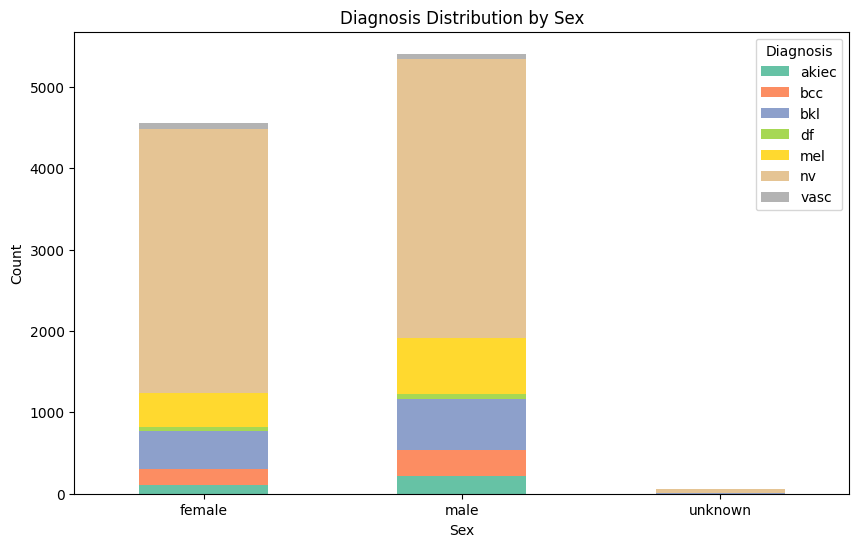

In [ ]:
#Sex vs Diagnosis (Stacked Bar Chart)

sex_dx = pd.crosstab(metadata['sex'], metadata['dx'])
sex_dx.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title('Diagnosis Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Diagnosis')
plt.xticks(rotation=0)
plt.show()

<ipython-input-17-22222d9f1414>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=metadata, x='localization', order=metadata['localization'].value_counts().index, palette='Blues')


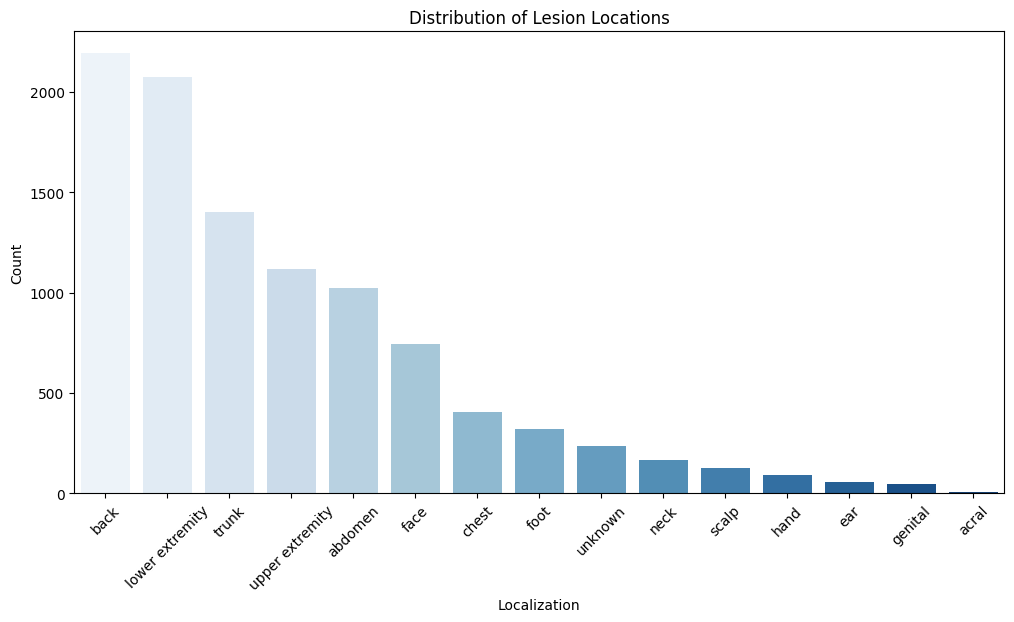

In [ ]:
#Localization Distribution (Bar Chart)

plt.figure(figsize=(12, 6))
sns.countplot(data=metadata, x='localization', order=metadata['localization'].value_counts().index, palette='Blues')
plt.title('Distribution of Lesion Locations')
plt.xlabel('Localization')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

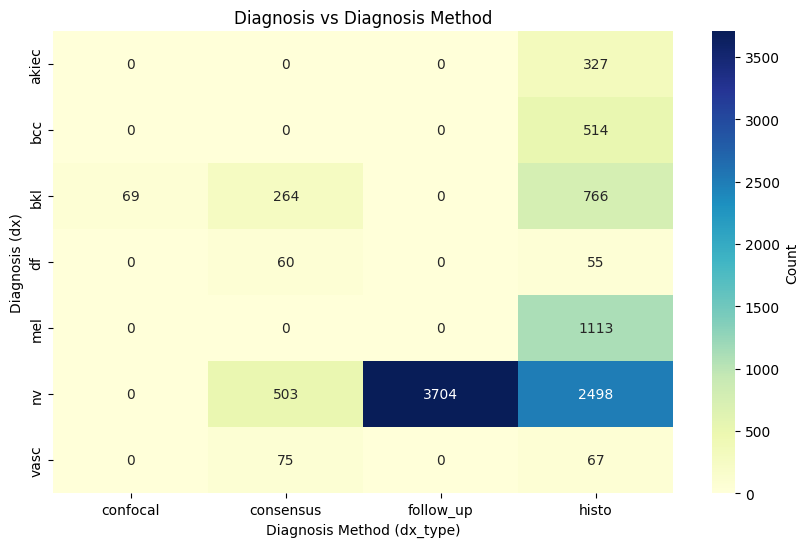

In [ ]:
#Diagnosis vs Diagnosis Method (Heatmap)

dx_dx_type = pd.crosstab(metadata['dx'], metadata['dx_type'])
plt.figure(figsize=(10, 6))
sns.heatmap(dx_dx_type, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'})
plt.title('Diagnosis vs Diagnosis Method')
plt.xlabel('Diagnosis Method (dx_type)')
plt.ylabel('Diagnosis (dx)')
plt.show()

Number of different skin diseases in the dataset: 7

Disease distribution:
nv: 6705 images (66.95%)
mel: 1113 images (11.11%)
bkl: 1099 images (10.97%)
bcc: 514 images (5.13%)
akiec: 327 images (3.27%)
vasc: 142 images (1.42%)
df: 115 images (1.15%)


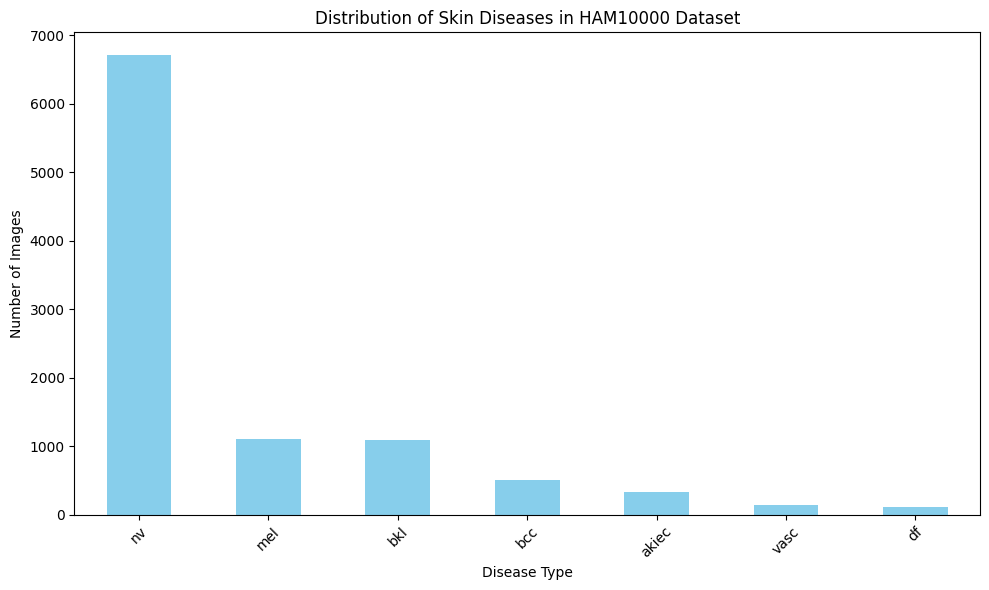

In [ ]:
# Count the number of different disease classes in the dataset
unique_diseases = metadata['dx'].unique()
num_diseases = len(unique_diseases)

print(f"Number of different skin diseases in the dataset: {num_diseases}")

# Display the distribution of diseases
disease_counts = metadata['dx'].value_counts()
print("\nDisease distribution:")
for disease, count in disease_counts.items():
    percentage = (count / len(metadata)) * 100
    print(f"{disease}: {count} images ({percentage:.2f}%)")

# Visualize the distribution with a bar plot
plt.figure(figsize=(10, 6))
disease_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Skin Diseases in HAM10000 Dataset')
plt.xlabel('Disease Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Data Pre-processing

In [ ]:

# Create a label_map to convert string labels to integers
label_map = {
    'bkl': 0,  # Benign Keratosis
    'nv': 1,   # Melanocytic Nevus
    'df': 2,   # Dermatofibroma
    'mel': 3,  # Melanoma
    'vasc': 4, # Vascular Lesions
    'bcc': 5,  # Basal Cell Carcinoma
    'akiec': 6 # Actinic Keratosis
}

class HAM10000Dataset(Dataset):

    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']
        label_str = self.dataframe.iloc[idx]['dx']
        label = label_map[label_str]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

# Data Augmentation and Preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Dataset and Apply Transformations
metadata = pd.read_csv('/content/HAM10000/HAM10000_metadata')
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join('HAM10000/images', f'{x}.jpg'))

# Split Dataset into Train and Validation
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)

train_dataset = HAM10000Dataset(train_df, transform=transform)
val_dataset = HAM10000Dataset(val_df, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


### Early Stopping

In [ ]:
class EarlyStopping:
    """
    Early stopping to prevent overfitting.
    Args:
        patience (int): How many epochs to wait after last validation loss improvement.
        verbose (bool): If True, prints a message for each validation loss improvement.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
    """
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False

### Loading Models

In [ ]:

# --- Step 2: Model Setup ---
model_name_b16 = "google/vit-base-patch16-224-in21k"
model_name_hiera = "facebook/hiera-base-224-in1k-hf"

# Load the pretrained ViT models
model_b16 = AutoModelForImageClassification.from_pretrained(model_name_b16)
model_hiera = AutoModelForImageClassification.from_pretrained(model_name_hiera)

# Modify the classifier head for 7 classes (HAM10000 dataset)
model_b16.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Apply dropout with a rate of 50%
    nn.Linear(model_b16.config.hidden_size, 7)
)

model_hiera.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Apply dropout with a rate of 50%
    nn.Linear(model_hiera.config.hidden_size, 7)
)

# Move models to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b16.to(device)
model_hiera.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/206M [00:00<?, ?B/s]

HieraForImageClassification(
  (hiera): HieraModel(
    (embeddings): HieraEmbeddings(
      (patch_embeddings): HieraPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
    )
    (encoder): HieraEncoder(
      (stages): ModuleList(
        (0): HieraStage(
          (layers): ModuleList(
            (0-1): 2 x HieraLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (attn): HieraMaskUnitAttention(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (proj): Linear(in_features=96, out_features=96, bias=True)
              )
              (layernorm_after): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (mlp): HieraMlp(
                (activation_fn): GELUActivation()
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (fc2): Linear(in_features=384, out_features=96, bias=True)

### Training Model

In [ ]:
def train_model(model, train_dataloader, val_dataloader, epochs=5, name="best_model"):
    optimizer = AdamW(model.parameters(), lr=1e-5)
    criterion = nn.CrossEntropyLoss()
    earlyy_stopping = EarlyStopping(patience=5, verbose=True)

    best_accuracy = 0.0
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    epoch_times = []  # To store time taken per epoch
    memory_usages = []  # To store memory usage per epoch (in MB)

    # Check if running on GPU
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        start_time = time.time()

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            logits = outputs.logits

            # Compute loss
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(logits, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_accuracy = correct_train / total_train
        print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)

        # Validation Phase
        model.eval()
        correct_val = 0
        total_val = 0
        val_running_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                logits = outputs.logits

                loss = criterion(logits, labels)
                val_running_loss += loss.item() * images.size(0)

                _, predicted = torch.max(logits, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss_epoch = val_running_loss / len(val_dataloader.dataset)
        val_accuracy_epoch = correct_val / total_val
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss_epoch:.4f}, Accuracy: {val_accuracy_epoch:.4f}")

        val_loss.append(val_loss_epoch)
        val_accuracy.append(val_accuracy_epoch)

        # Measure memory usage
        if use_cuda:
            # GPU memory usage in MB
            memory_usage = torch.cuda.memory_allocated(device) / (1024 ** 2)  # Convert bytes to MB
        else:
            # CPU memory usage using psutil (if available)
            if psutil_available:
                process = psutil.Process(os.getpid())
                memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert bytes to MB
            else:
                memory_usage = 0  # Placeholder if psutil is not available
                print("Warning: psutil not installed. Cannot track CPU memory usage.")
        memory_usages.append(memory_usage)
        print(f"Epoch {epoch+1}, Memory Usage: {memory_usage:.2f} MB")

        # Save the best model based on validation accuracy
        if val_accuracy_epoch > best_accuracy:
            best_accuracy = val_accuracy_epoch
            save_dir = "/content/drive/best_model_google"
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{name}_best.pth")
            torch.save(model.state_dict(), save_path)
            print(f"Saved the best model with accuracy: {val_accuracy_epoch:.4f}")

        if earlyy_stopping(val_loss_epoch, model):
            print("Early stopping triggered.")
            break

        end_time = time.time()
        epoch_time = end_time - start_time
        epoch_times.append(epoch_time)
        print(f"Time taken for epoch {epoch+1}: {epoch_time:.2f} seconds")

    print("Training complete.")
    print(f"Best validation accuracy: {best_accuracy:.4f}")
    print("Plotting Visualizations, ROC, and Confusion Matrix")

    # Plot existing visualizations (unchanged)
    plot_loss(train_loss, val_loss, len(train_loss))
    plot_accuracy(train_accuracy, val_accuracy, len(train_accuracy))
    plot_confusion_matrix(all_labels, all_preds, classes=["Melanoma", "Basal Cell Carcinoma", "Benign Keratosis", "Vascular Lesions", "Actinic Keratosis", "Dermatofibroma", "Nevus"])
    plot_roc_curve(all_labels, all_preds, num_classes=7)

    print("----------------------------------------------------------------------------")
    return epoch_times, val_accuracy, memory_usages  # Return epoch times, validation accuracies, and memory usage

### Visualizations

In [ ]:
# Function to plot Training & Validation Loss
def plot_loss(train_loss, val_loss, epochs):
    plt.figure(figsize=(10,6))
    plt.plot(range(epochs), train_loss, label='Training Loss')
    plt.plot(range(epochs), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot Training & Validation Accuracy
def plot_accuracy(train_accuracy, val_accuracy, epochs):
    plt.figure(figsize=(10,6))
    plt.plot(range(epochs), train_accuracy, label='Training Accuracy')
    plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot ROC Curve
def plot_roc_curve(y_true, y_pred, num_classes):
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Function to plot computational time, memory usage, and accuracy comparison using a twin-axis plot
def plot_time_memory_accuracy_comparison(vit_times, vit_accuracies, vit_memory, hiera_times, hiera_accuracies, hiera_memory, epochs):

    # Plot 1: Computational Time Comparison
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(vit_times) + 1), vit_times, label='ViT-B16 Time', marker='o', color='blue', linestyle='-')
    plt.plot(range(1, len(hiera_times) + 1), hiera_times, label='Hiera Time', marker='s', color='orange', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title('Computational Time Comparison: ViT-B16 vs Hiera Transformer')
    plt.savefig(os.path.join('/content/drive/plots', 'computational_time.png'), bbox_inches='tight')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Memory Usage Comparison
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(vit_memory) + 1), vit_memory, label='ViT-B16 Memory', marker='^', color='blue', linestyle='-')
    plt.plot(range(1, len(hiera_memory) + 1), hiera_memory, label='Hiera Memory', marker='v', color='orange', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Memory (MB)')
    plt.title('Memory Usage Comparison: ViT-B16 vs Hiera Transformer')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join('/content/drive/plots', 'memory_usage.png'), bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    # Plot 3: Validation Accuracy Comparison
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(vit_accuracies) + 1), vit_accuracies, label='ViT-B16 Accuracy', marker='d', color='blue', linestyle='--')
    plt.plot(range(1, len(hiera_accuracies) + 1), hiera_accuracies, label='Hiera Accuracy', marker='d', color='orange', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy Comparison: ViT-B16 vs Hiera Transformer')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join('/content/drive/plots', 'accuracy_comparison.png'), bbox_inches='tight')
    plt.tight_layout()
    plt.show()


### Running the model by invoking train_model

Training ViT-B16 Model:
Epoch 1, Training Loss: 0.8233, Accuracy: 0.7318
Epoch 1, Validation Loss: 0.7660, Accuracy: 0.7464
Epoch 1, Memory Usage: 2205.60 MB
Saved the best model with accuracy: 0.7464
Time taken for epoch 1: 438.30 seconds
Epoch 2, Training Loss: 0.7031, Accuracy: 0.7771
Epoch 2, Validation Loss: 0.6479, Accuracy: 0.7923
Epoch 2, Memory Usage: 2205.60 MB
Saved the best model with accuracy: 0.7923
Time taken for epoch 2: 434.84 seconds
Epoch 3, Training Loss: 0.6137, Accuracy: 0.8073
Epoch 3, Validation Loss: 0.6396, Accuracy: 0.7953
Epoch 3, Memory Usage: 2205.60 MB
Saved the best model with accuracy: 0.7953
Time taken for epoch 3: 431.11 seconds
Epoch 4, Training Loss: 0.5481, Accuracy: 0.8330
Epoch 4, Validation Loss: 0.5268, Accuracy: 0.8392
Epoch 4, Memory Usage: 2205.60 MB
Saved the best model with accuracy: 0.8392
Time taken for epoch 4: 435.50 seconds
Epoch 5, Training Loss: 0.4907, Accuracy: 0.8530
Epoch 5, Validation Loss: 0.5159, Accuracy: 0.8357
Epoch 5, Mem

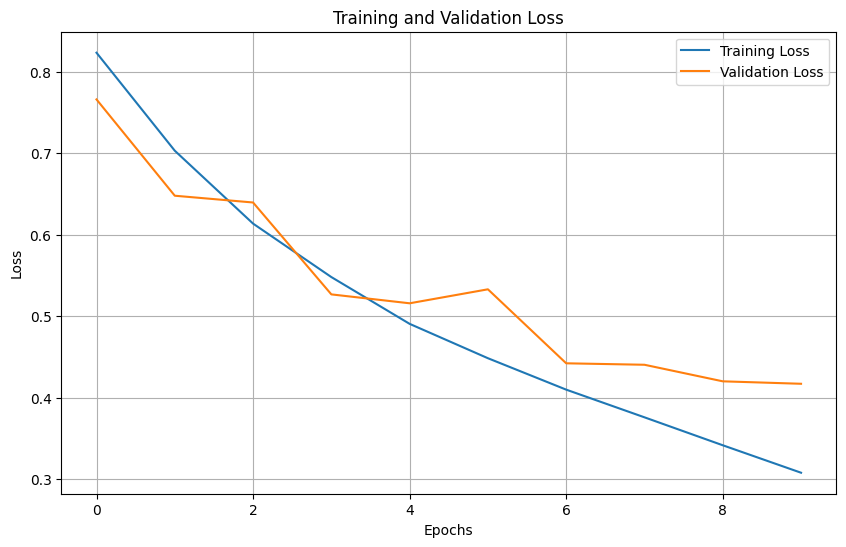

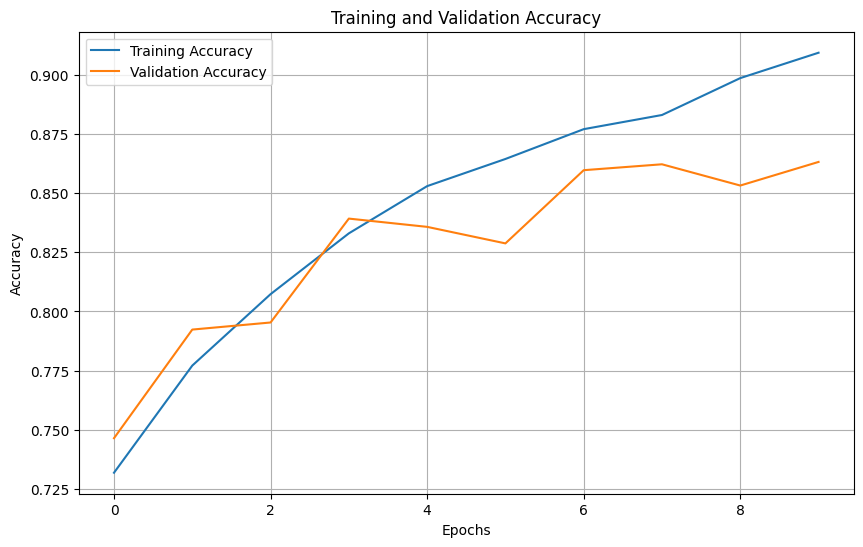

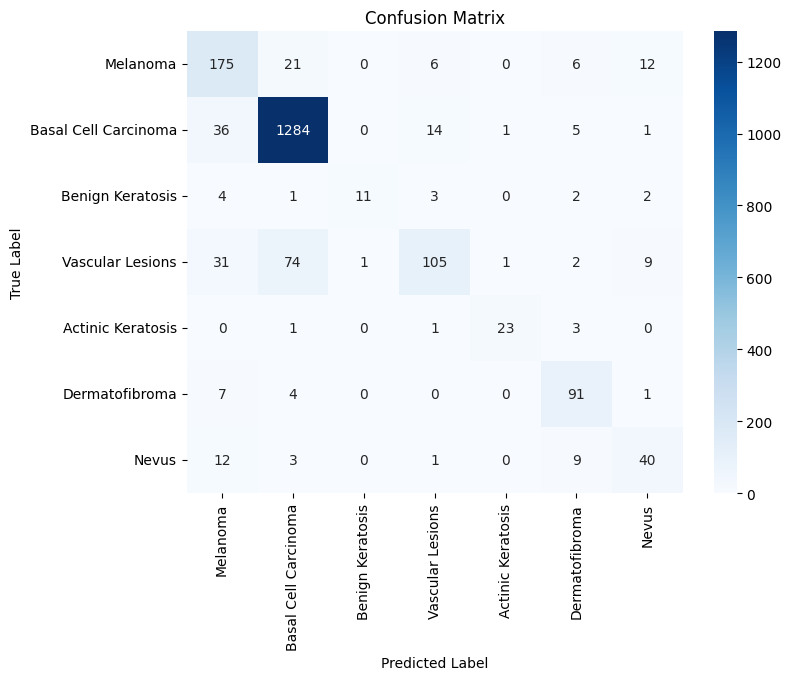

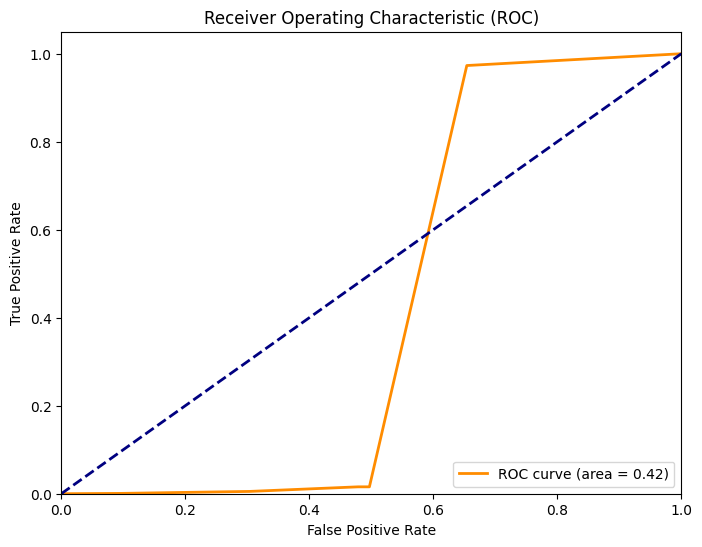

----------------------------------------------------------------------------
Training Hiera-Transformer Model:
Epoch 1, Training Loss: 0.8736, Accuracy: 0.7046
Epoch 1, Validation Loss: 0.6857, Accuracy: 0.7693
Epoch 1, Memory Usage: 2164.12 MB
Saved the best model with accuracy: 0.7693
Time taken for epoch 1: 348.50 seconds
Epoch 2, Training Loss: 0.6572, Accuracy: 0.7685
Epoch 2, Validation Loss: 0.6005, Accuracy: 0.7923
Epoch 2, Memory Usage: 2164.12 MB
Saved the best model with accuracy: 0.7923
Time taken for epoch 2: 347.49 seconds
Epoch 3, Training Loss: 0.5617, Accuracy: 0.8060
Epoch 3, Validation Loss: 0.5346, Accuracy: 0.8168
Epoch 3, Memory Usage: 2164.12 MB
Saved the best model with accuracy: 0.8168
Time taken for epoch 3: 346.91 seconds
Epoch 4, Training Loss: 0.4925, Accuracy: 0.8306
Epoch 4, Validation Loss: 0.4958, Accuracy: 0.8258
Epoch 4, Memory Usage: 2164.12 MB
Saved the best model with accuracy: 0.8258
Time taken for epoch 4: 346.53 seconds
Epoch 5, Training Loss: 0

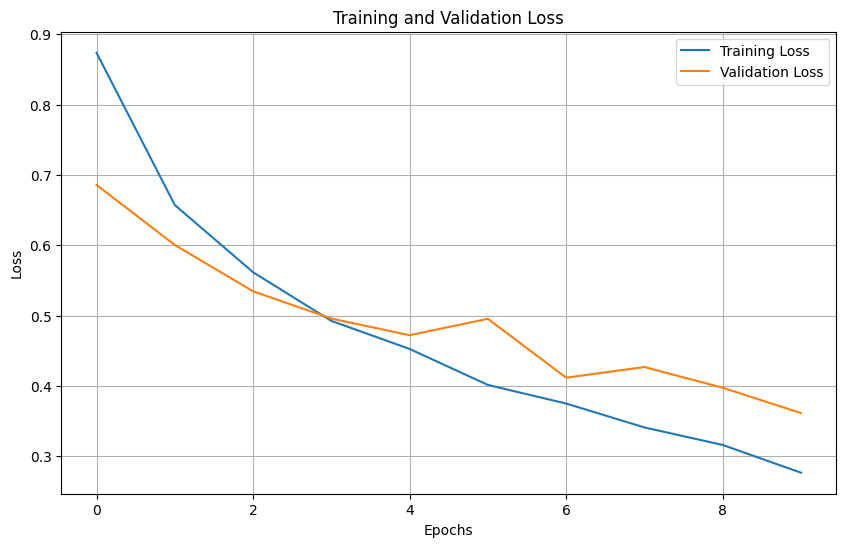

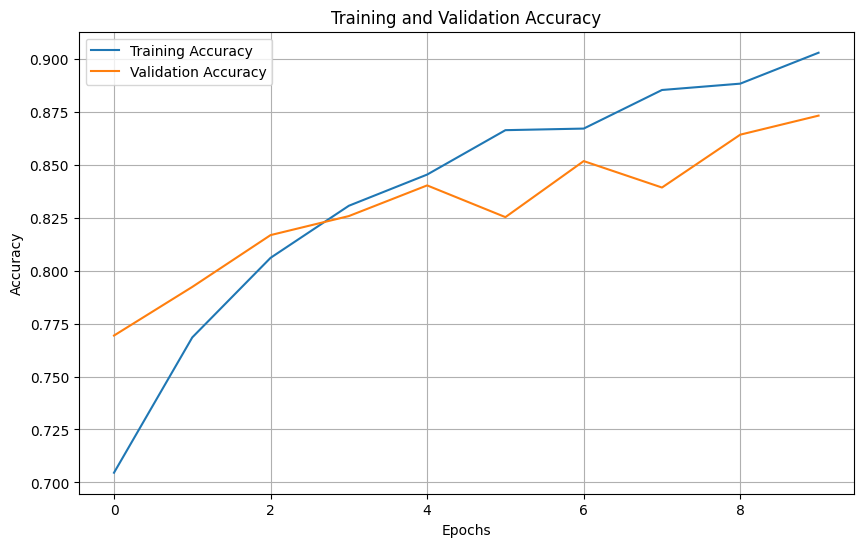

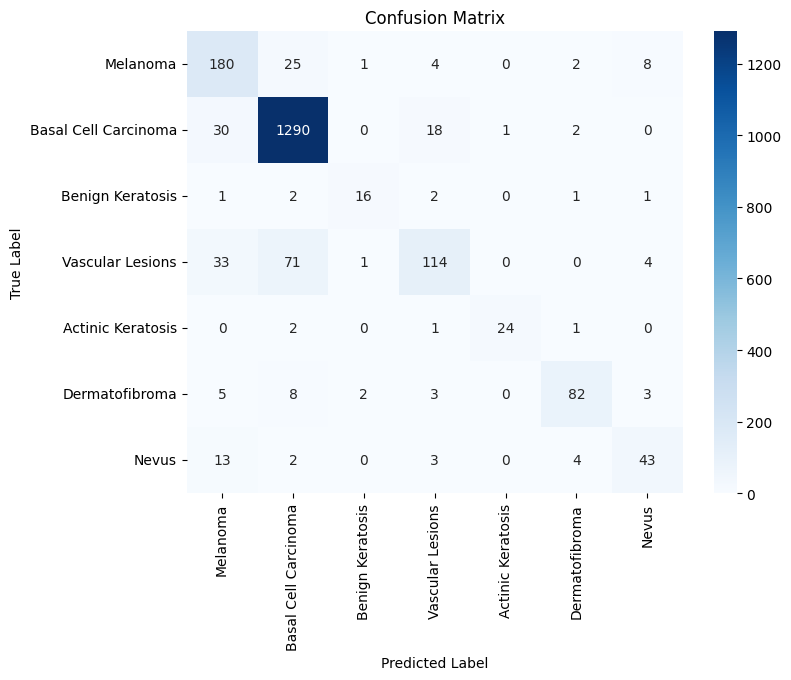

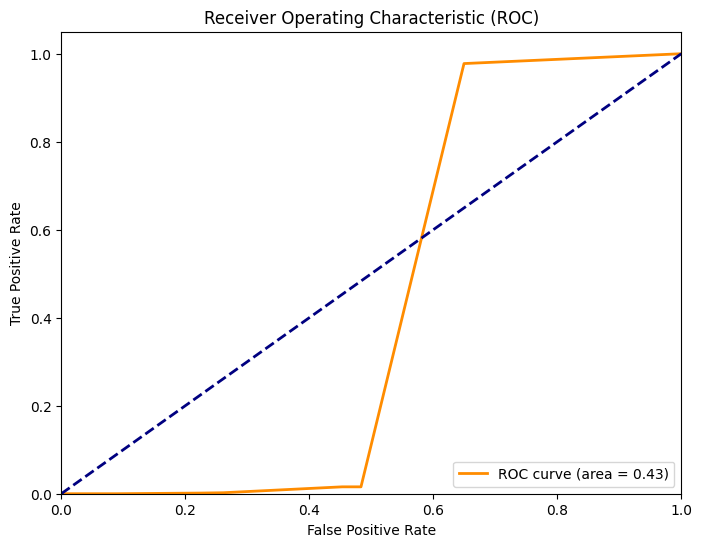

----------------------------------------------------------------------------


In [ ]:
# Run the training and collect computational times, accuracies, and memory usage
print("Training ViT-B16 Model:")
vit_times, vit_accuracies, vit_memory = train_model(model_b16, train_dataloader, val_dataloader, epochs=10, name="b-16")

print("Training Hiera-Transformer Model:")
hiera_times, hiera_accuracies, hiera_memory = train_model(model_hiera, train_dataloader, val_dataloader, epochs=10, name="hiera")

## Plotting comparisions of time, memory and accuracy of both models

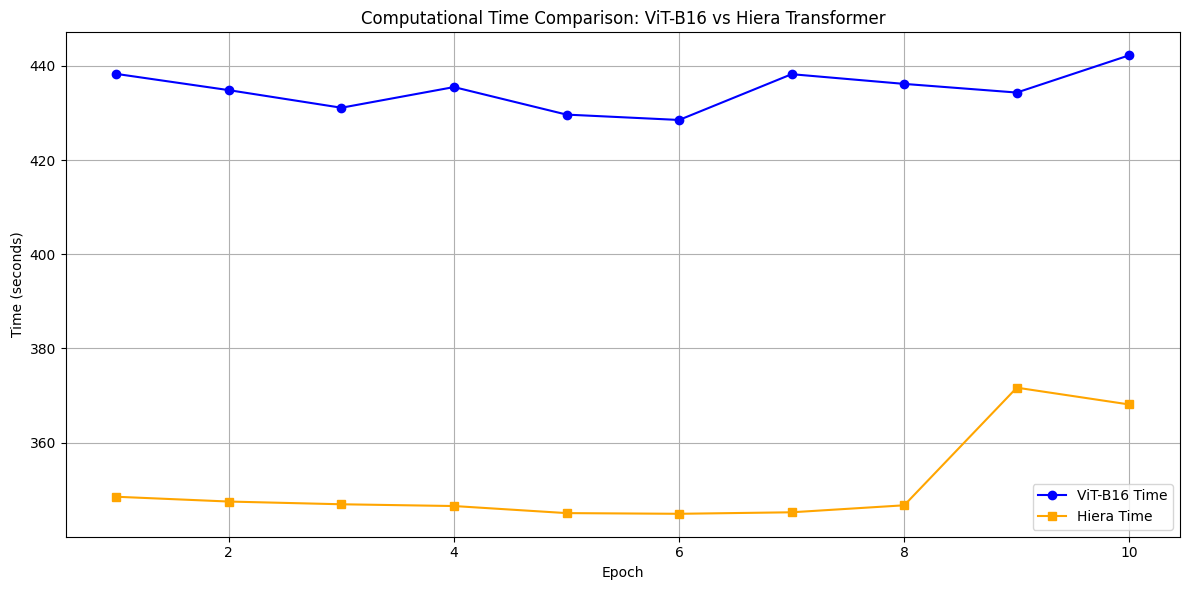

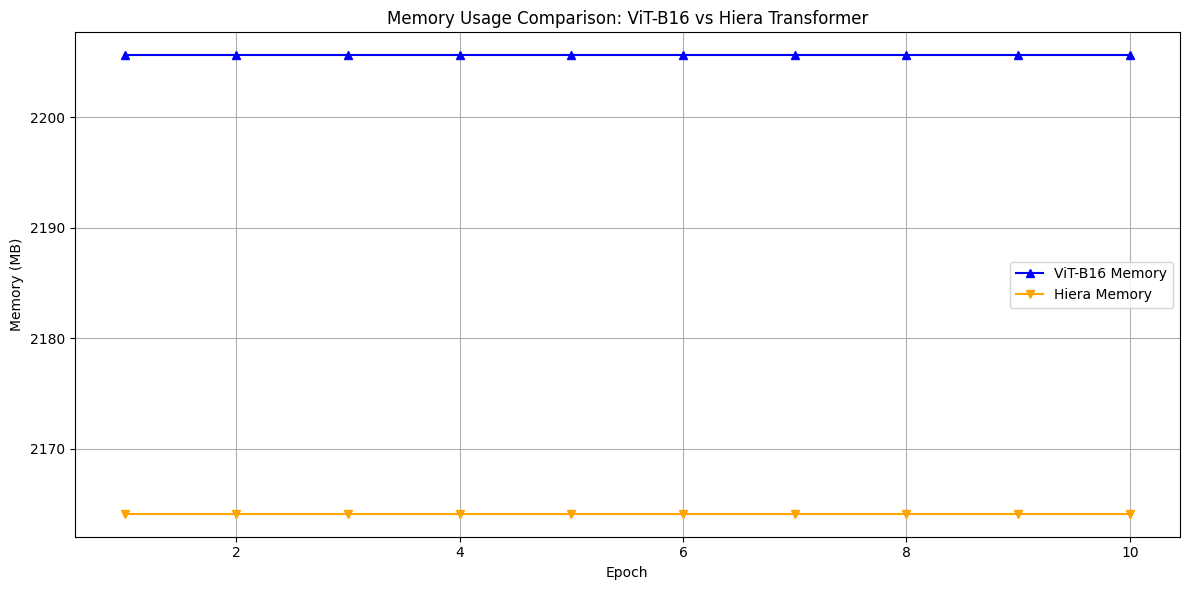

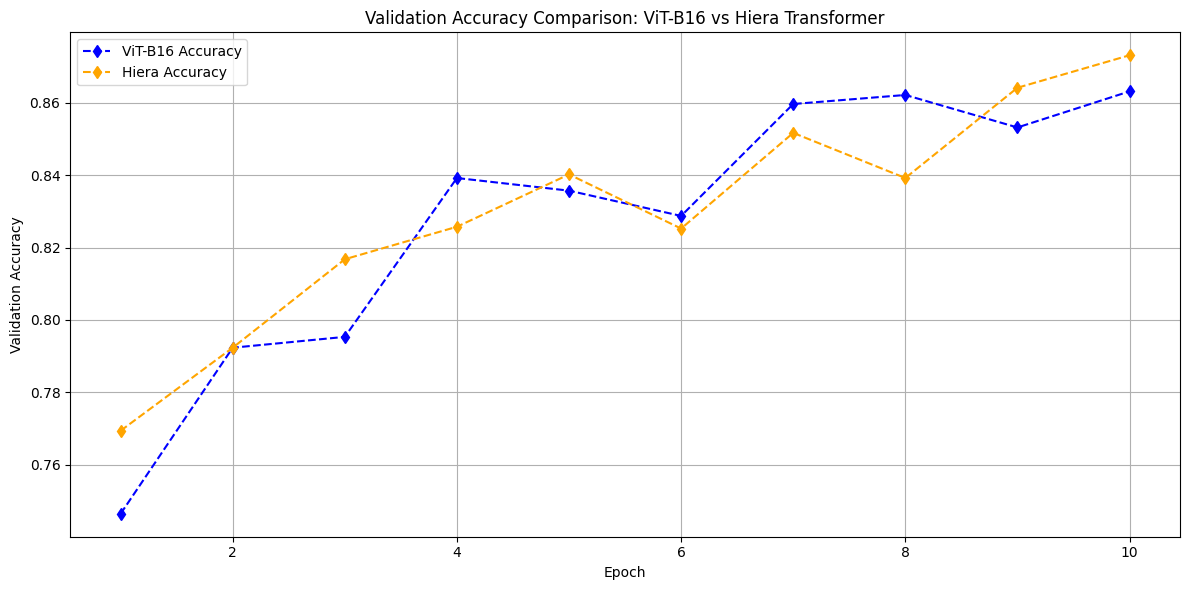

In [ ]:
# Plot the time, memory, and accuracy comparison
plot_time_memory_accuracy_comparison(vit_times, vit_accuracies, vit_memory, hiera_times, hiera_accuracies, hiera_memory, min(len(vit_times), len(hiera_times)))

### Model Evaluation

In [ ]:
def evaluate_model_with_metrics(model, test_dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    correct = 0
    total = 0
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits

            loss = criterion(logits, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate metrics
    test_loss = test_loss / len(test_dataloader.dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Print results
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision (Weighted): {test_precision:.4f}")
    print(f"F1 Score (Weighted): {test_f1:.4f}")

    # Plot confusion matrix and ROC curve
    classes = ["Melanoma", "Basal Cell Carcinoma", "Benign Keratosis", "Vascular Lesions", "Actinic Keratosis", "Dermatofibroma", "Nevus"]
    plot_confusion_matrix(all_labels, all_preds, classes=classes)
    plot_roc_curve(all_labels, all_preds, num_classes=7)

    return test_accuracy, test_precision, test_f1

## Model Evaluation based on test images of HAM10000 dataset

In [ ]:
!unzip -qq HAM10000/ISIC2018_Task3_Test_Images.zip -d HAM10000/test_images/

In [ ]:
test_metadata_path = "HAM10000/ISIC2018_Task3_Test_GroundTruth.csv"
test_metadata = pd.read_csv(test_metadata_path)

# test_metadata['dx'] = test_metadata['dx'].str.lower().map(label_map)

# Add image paths using the 'image_id' column
test_metadata['image_path'] = test_metadata['image_id'].apply(lambda x: os.path.join('/content/HAM10000/test_images/ISIC2018_Task3_Test_Images', f'{x}.jpg'))

# Dropping rows with missing labels (if any)
test_metadata = test_metadata.dropna(subset=['dx'])

# Filter out rows where the image file does not exist
original_count = len(test_metadata)
test_metadata['image_exists'] = test_metadata['image_path'].apply(os.path.exists)
test_metadata = test_metadata[test_metadata['image_exists']].drop(columns=['image_exists'])
skipped_count = original_count - len(test_metadata)

print(f"Total test images in metadata: {original_count}")
print(f"Images skipped due to missing files: {skipped_count}")
print(f"Images available for evaluation: {len(test_metadata)}")

print(test_metadata.head())

Total test images in metadata: 1512
Images skipped due to missing files: 1
Images available for evaluation: 1511
         lesion_id      image_id   dx    dx_type   age     sex localization  \
0  HAMTEST_0000000  ISIC_0034524   nv  follow_up  40.0  female         back   
1  HAMTEST_0000001  ISIC_0034525   nv      histo  70.0    male      abdomen   
2  HAMTEST_0000002  ISIC_0034526  bkl      histo  70.0    male         back   
3  HAMTEST_0000003  ISIC_0034527   nv      histo  35.0    male        trunk   
4  HAMTEST_0000004  ISIC_0034528   nv  follow_up  75.0  female        trunk   

         dataset                                         image_path  
0  vidir_molemax  /content/HAM10000/test_images/ISIC2018_Task3_T...  
1      rosendahl  /content/HAM10000/test_images/ISIC2018_Task3_T...  
2      rosendahl  /content/HAM10000/test_images/ISIC2018_Task3_T...  
3    vienna_dias  /content/HAM10000/test_images/ISIC2018_Task3_T...  
4  vidir_molemax  /content/HAM10000/test_images/ISIC2018_Task3

In [ ]:
# Generating test dataloader
test_dataset = HAM10000Dataset(test_metadata, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def evaluate_model_with_metrics(model, test_dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    correct = 0
    total = 0
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits

            loss = criterion(logits, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate metrics
    test_loss = test_loss / len(test_dataloader.dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Print results
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision (Weighted): {test_precision:.4f}")
    print(f"F1 Score (Weighted): {test_f1:.4f}")

In [ ]:
# Evaluate ViT-B16 on test data
print("Evaluating ViT-B16 on Test Data:")
evaluate_model_with_metrics(model_b16, test_dataloader)

# Evaluate Hiera on test data
print("\n\nEvaluating Hiera on Test Data:")
evaluate_model_with_metrics(model_hiera, test_dataloader)

Evaluating ViT-B16 on Test Data:
Test Loss: 0.5752
Accuracy: 0.8167
Precision (Weighted): 0.8182
F1 Score (Weighted): 0.8075


Evaluating Hiera on Test Data:
Test Loss: 0.5292
Accuracy: 0.8326
Precision (Weighted): 0.8290
F1 Score (Weighted): 0.8254
